In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

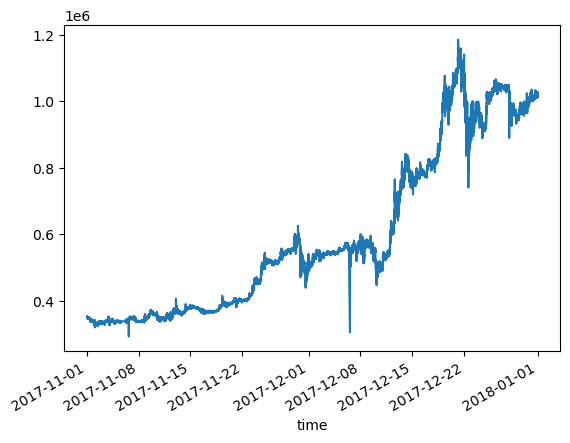

In [2]:
# 데이터 불러오기
modify_data = pd.read_csv(os.path.join('sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

하이퍼 파라미터 튜닝 결과 AUC 0.685 -> 0.697로 상승 시간부족으로 더 올리진 못함

In [3]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

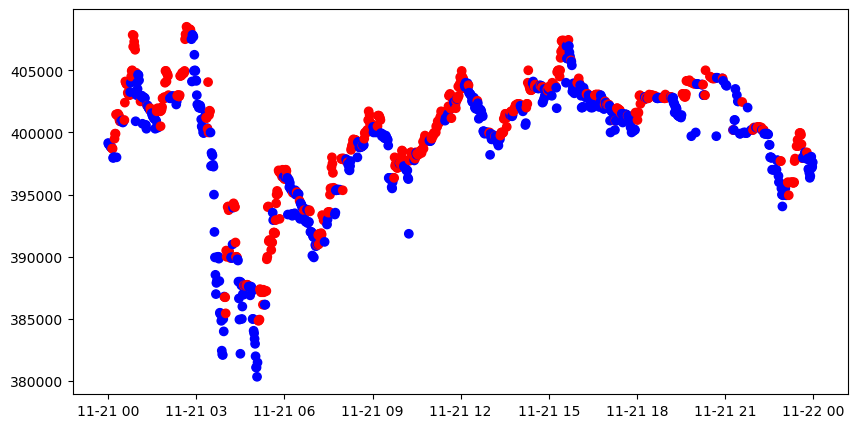

In [4]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [5]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

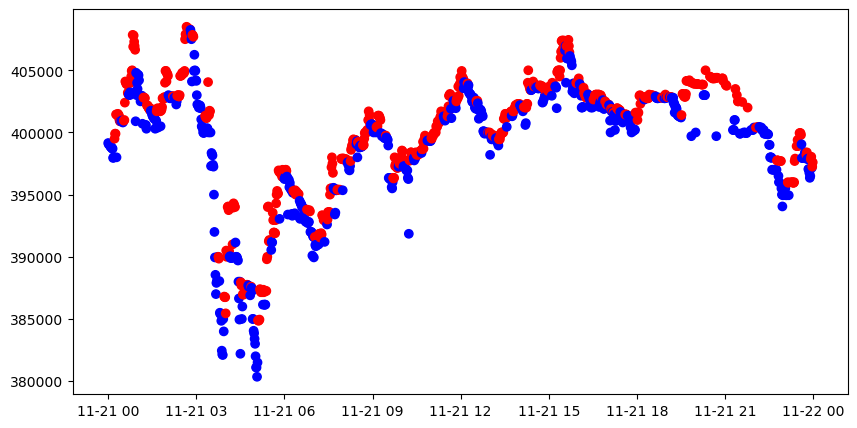

In [6]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [7]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

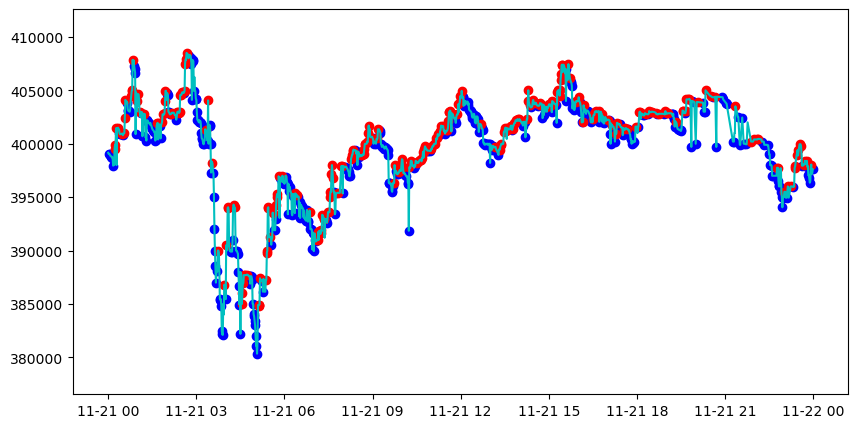

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [10]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [11]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [12]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|████████████████████████████████████████████████████████████████████████████| 33384/33384 [19:09<00:00, 29.05it/s]


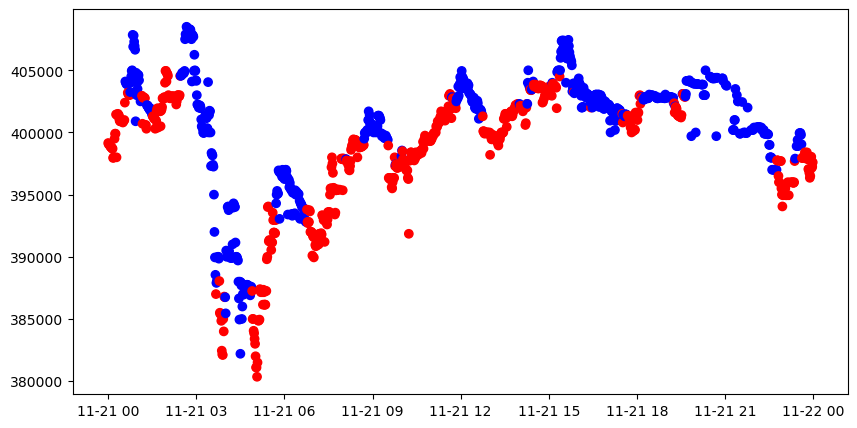

In [13]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

In [14]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/Users/USER/DataScientist_4/timeseries')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [15]:
# 데이터 경로 설정
anno_file_name = os.path.join('sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join('sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [16]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [17]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [18]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [19]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

In [20]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.042957,0.002150
volume_fi,0.041340,0.002243
volume_mfi,0.041912,0.002385
volume_sma_em,0.034983,0.001944
volume_vpt,0.025511,0.001745
volatility_atr,0.082675,0.003363
volatility_ui,0.049106,0.002412
trend_macd_diff,0.074225,0.003920
trend_adx,0.048627,0.002476
trend_trix,0.071780,0.002669


In [21]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [22]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

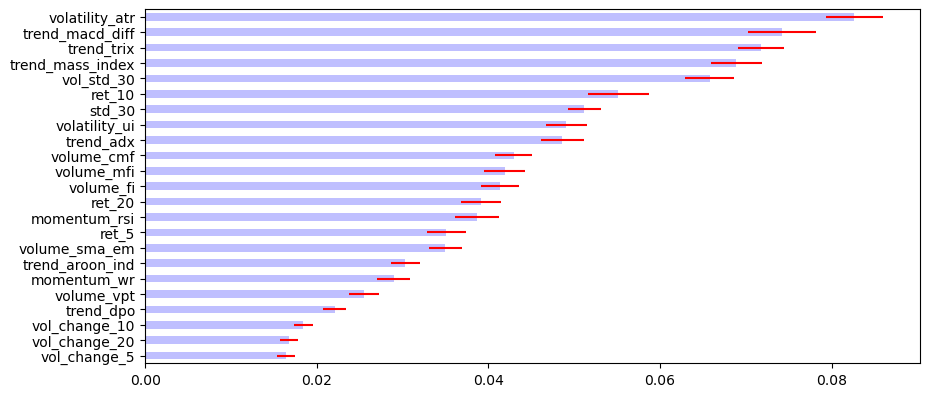

In [23]:
plot_feature_importance(feat_imp)

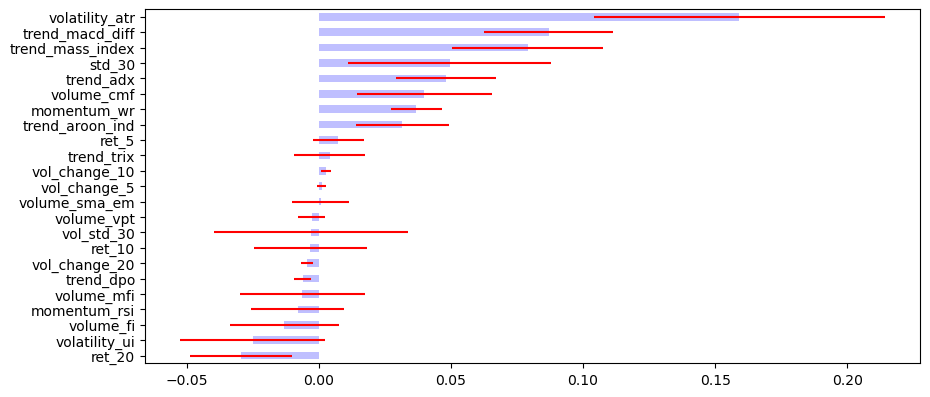

In [24]:
plot_feature_importance(feat_imp_mda)

In [25]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [26]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [27]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


In [28]:
n = 3

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [29]:
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(
    {"Optimal_Features": sfs_rank},     # 딕셔너리 → 자동으로 (n_features, 1) 변환
    index=X_sc.columns
)

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff', 'trend_dpo'], dtype='object')

<Figure size 640x480 with 0 Axes>

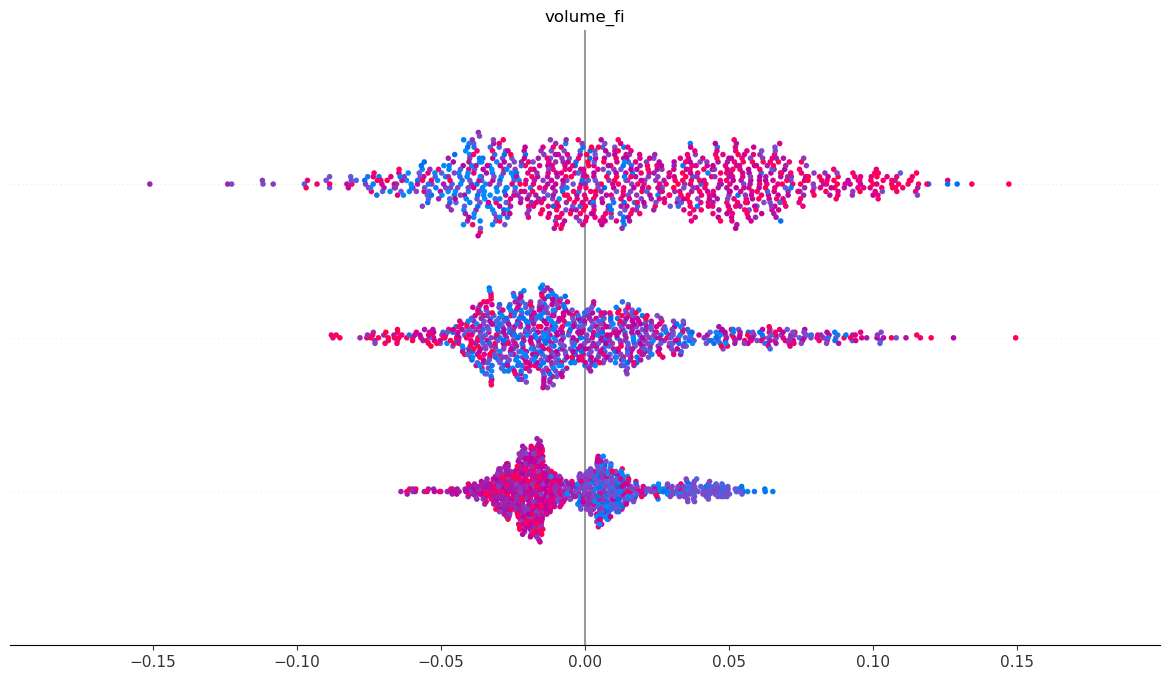

In [30]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

shap.summary_plot(shap_value, X_sc)

In [31]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/Users/USER/DataScientist_4/timeseries')
from libs.mlutil.pkfold import PKFold

In [33]:
# 데이터 경로 설정 및 pickle 파일 불러오기
data_file_name = os.path.join('sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [34]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [53]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [62]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_samples=0.7)

In [63]:
bag_rfc = BaggingClassifier(estimator=rfc)

In [64]:
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [65]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features=None,
                                                   max_samples=0.7,
                                                   min_samples_leaf=10),
                  max_features=0.5)

In [66]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [67]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[81 55]
 [11 44]]
정확도:0.6544502617801047, 정밀도:0.4444444444444444, 재현율:0.8


auc:0.6977941176470588


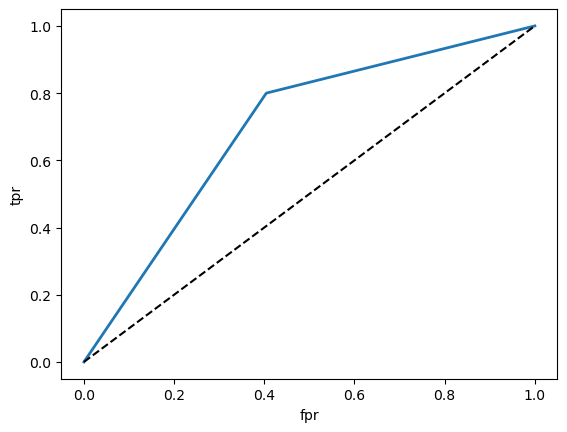

In [68]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')